In [1]:
import pandas as pd

# 1) Load
df = pd.read_csv(r"C:\Users\DEV\Desktop\Minor Project\Project\powerbi_export_vv1\part-00000-f68680cb-f6a2-41a1-a0d1-4780a3894542-c000.csv")

# 2) Basic type conversions (no value change)
df["Timestamp_UTC"] = pd.to_datetime(df["Timestamp_UTC"], utc=True, errors="coerce")

# If your column names differ, adjust here:
# e.g. "State" instead of "State_Code", etc.

# 3) Sort just for easier plotting (does NOT change values)
df = df.sort_values(["State_Code", "Timestamp_UTC"]).reset_index(drop=True)

# 4) Create an 'error' column (we can ignore rows where actual or predicted is missing)
df["Error_MW"] = df["Predicted_Load_MW"] - df["Gross_Load_MW"]
df["Abs_Error_MW"] = df["Error_MW"].abs()
df["APE_pct"] = (df["Abs_Error_MW"] / df["Gross_Load_MW"]) * 100  # can be inf/NaN where Gross_Load_MW=0 or NaN

In [2]:
# Quick global view (ignores rows with missing actual/predicted)
valid = df.dropna(subset=["Gross_Load_MW", "Predicted_Load_MW"]).copy()

global_metrics = {
    "MAE_MW": valid["Abs_Error_MW"].mean(),
    "MAPE_pct": valid["APE_pct"].mean(),
    "RMSE_MW": (valid["Error_MW"]**2).mean()**0.5,
}
print(global_metrics)

# Per-state metrics
per_state = (
    valid
    .groupby("State_Code")
    .agg(
        MAE_MW=("Abs_Error_MW", "mean"),
        MAPE_pct=("APE_pct", "mean"),
        RMSE_MW=("Error_MW", lambda x: (x**2).mean()**0.5),
        n=("Error_MW", "size"),
    )
    .sort_values("MAPE_pct")
)
print(per_state)

{'MAE_MW': 696.8115656260417, 'MAPE_pct': 7.001035222021928, 'RMSE_MW': 1103.9327712738918}
                 MAE_MW   MAPE_pct      RMSE_MW   n
State_Code                                         
LA          1374.185494   3.062681  1811.424625  81
JK           675.676538   3.102321   922.784793  81
UP          1754.118125   4.710486  2116.915020  76
GJ          1312.897154   4.825246  1633.900202  76
RJ          1254.366641   4.925627  1522.992666  81
MP           992.188153   5.039093  1272.920456  76
PB           845.879328   5.302672  1118.443283  81
HP          1234.650560   5.599397  1586.083759  81
TN          1136.054869   5.743910  1591.423156  81
AP           863.271815   5.751405  1076.379745  81
TS           859.476692   5.847324  1040.235778  81
DNHD          64.729409   5.983359    79.790786  81
AN             5.875452   5.984793     7.497032  76
MH          1542.470107   6.079779  1834.127790  81
HR           924.079199   6.082694  1132.151413  81
DL           903.832540 

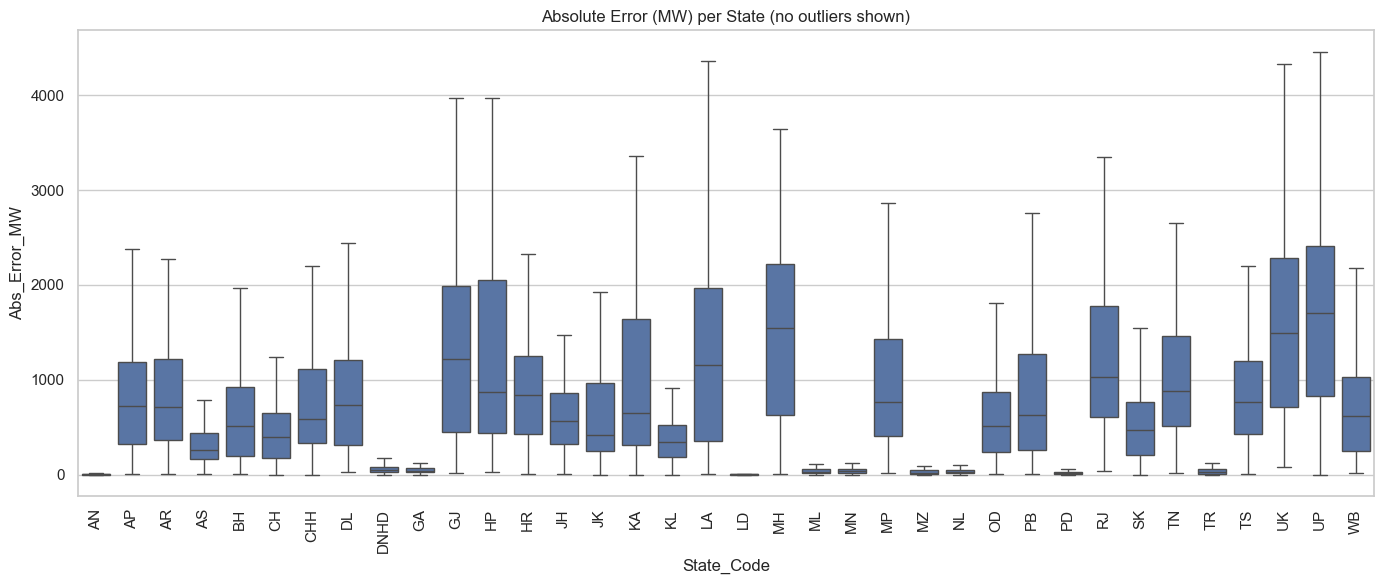

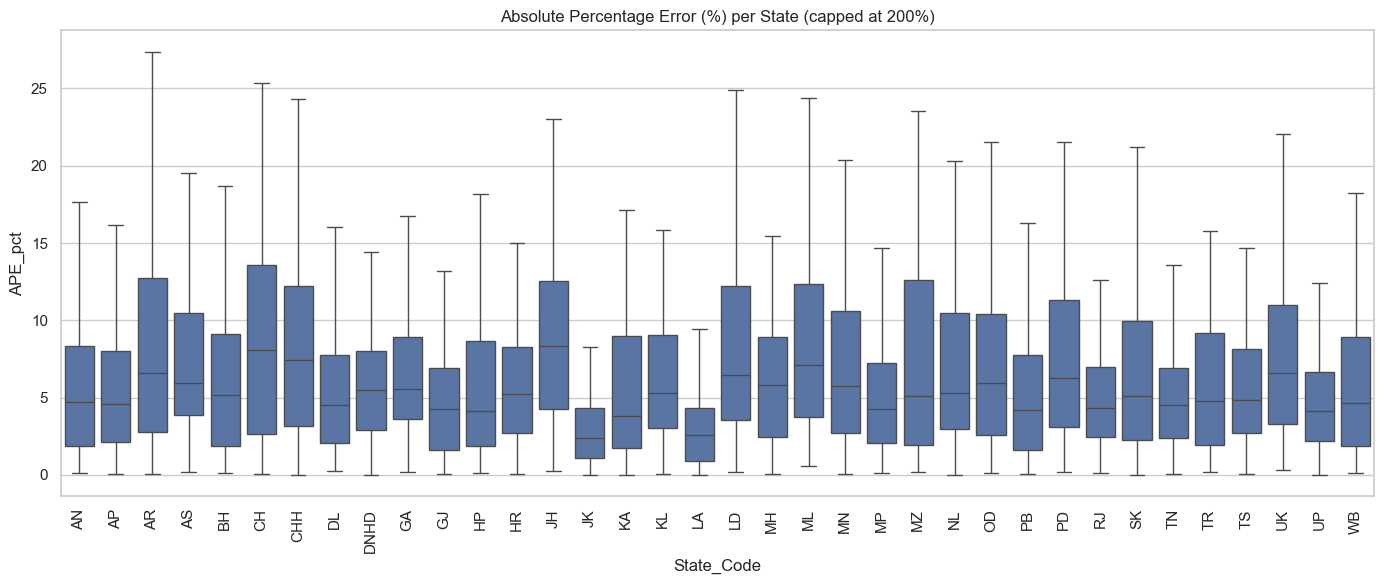

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Boxplot of absolute error (MW) per state ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=valid,
    x="State_Code",
    y="Abs_Error_MW",
    showfliers=False
)
plt.xticks(rotation=90)
plt.title("Absolute Error (MW) per State (no outliers shown)")
plt.tight_layout()
plt.show()

# --- Boxplot of APE% (percentage error) per state ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=valid[valid["APE_pct"].between(0, 200)],  # limit huge outliers for readability
    x="State_Code",
    y="APE_pct",
    showfliers=False
)
plt.xticks(rotation=90)
plt.title("Absolute Percentage Error (%) per State (capped at 200%)")
plt.tight_layout()
plt.show()

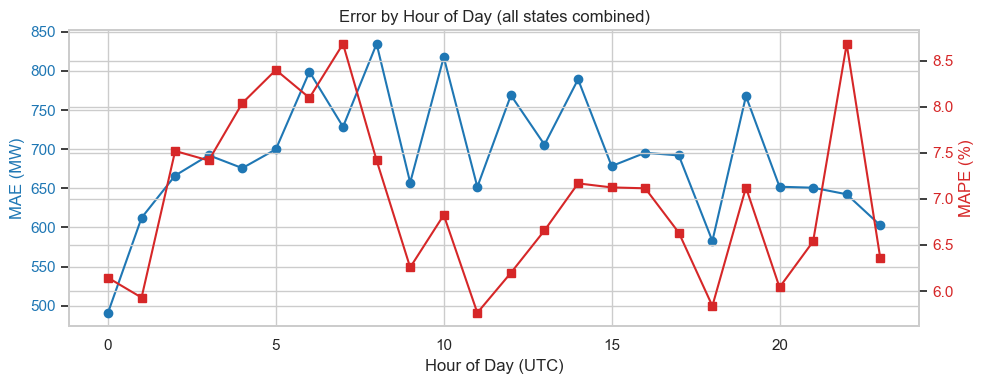

In [4]:
valid["hour"] = valid["Timestamp_UTC"].dt.hour

hourly_error = (
    valid
    .groupby("hour")
    .agg(
        MAE_MW=("Abs_Error_MW", "mean"),
        MAPE_pct=("APE_pct", "mean"),
        n=("Abs_Error_MW", "size"),
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10, 4))

color = "tab:blue"
ax1.set_xlabel("Hour of Day (UTC)")
ax1.set_ylabel("MAE (MW)", color=color)
ax1.plot(hourly_error["hour"], hourly_error["MAE_MW"], marker="o", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("MAPE (%)", color=color)
ax2.plot(hourly_error["hour"], hourly_error["MAPE_pct"], marker="s", color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Error by Hour of Day (all states combined)")
fig.tight_layout()
plt.show()

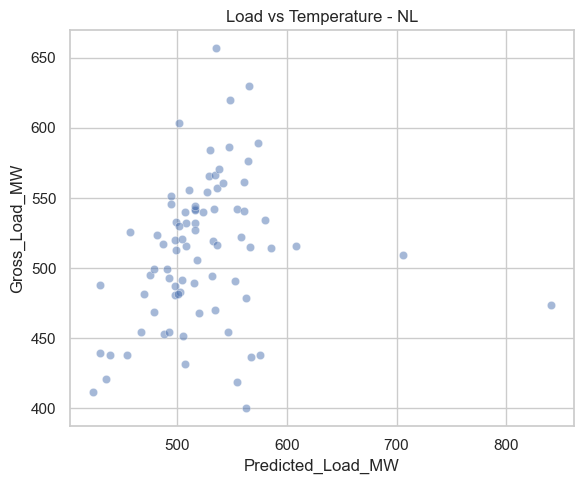

In [12]:
state = "NL"
sdf = df[(df["State_Code"] == state)].copy()

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=sdf,
    x="Predicted_Load_MW",
    y="Gross_Load_MW",
    alpha=0.5
)
plt.title(f"Load vs Temperature - {state}")
plt.tight_layout()
plt.show()

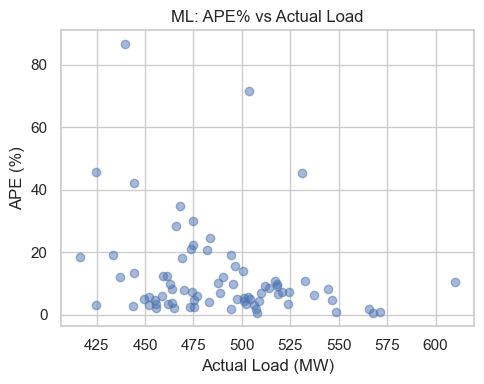

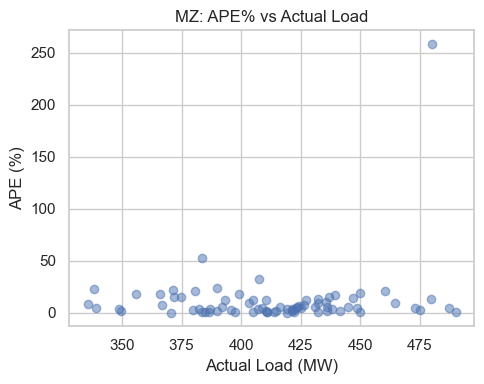

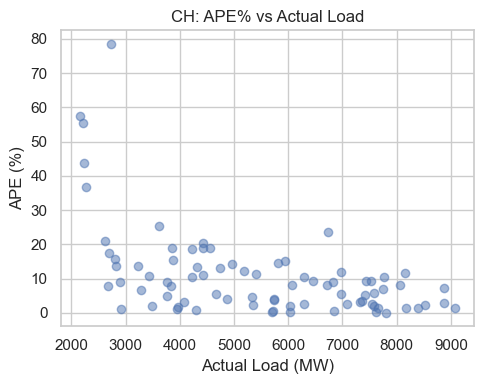

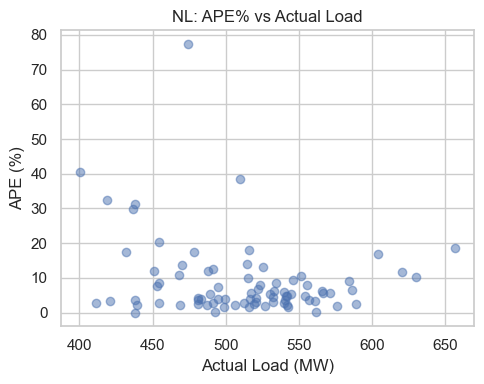

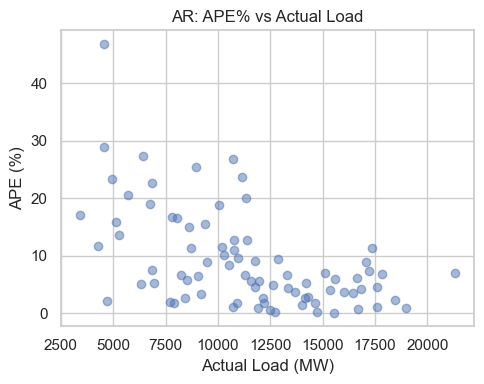

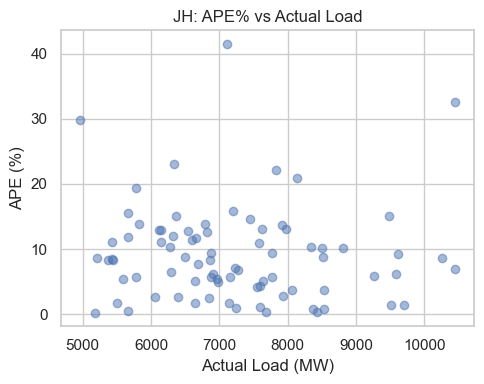

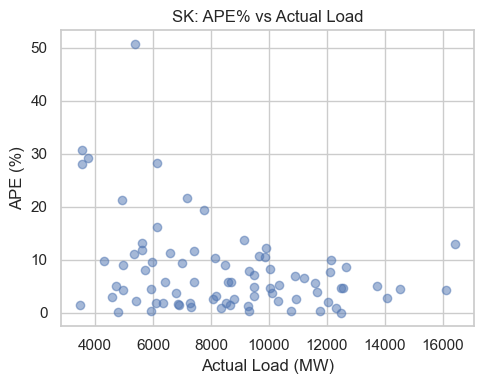

In [13]:
bad_states = ["ML", "MZ", "CH", "NL", "AR", "JH", "SK"]

for st in bad_states:
    sdf = valid[valid["State_Code"] == st].copy()
    sdf = sdf.dropna(subset=["Gross_Load_MW", "APE_pct"])

    plt.figure(figsize=(5,4))
    plt.scatter(sdf["Gross_Load_MW"], sdf["APE_pct"], alpha=0.5)
    plt.title(f"{st}: APE% vs Actual Load")
    plt.xlabel("Actual Load (MW)")
    plt.ylabel("APE (%)")
    plt.tight_layout()
    plt.show()

## Data Completeness

In [14]:
# 1. Count of missing values per column
df.isna().sum()

# 2. Percentage of missing values per column
(df.isna().mean() * 100).round(2)

State_Code           0.00
Timestamp_UTC        0.00
Gross_Load_MW        0.35
Predicted_Load_MW    0.00
Avg_Temp_C           0.35
Avg_Humidity_Pct     0.35
Is_Weekend           0.00
Error_MW             0.35
Abs_Error_MW         0.35
APE_pct              0.35
dtype: float64

In [15]:
cols_to_check = ["Gross_Load_MW", "Predicted_Load_MW", "Avg_Temp_C", "Avg_Humidity_Pct"]

missing_by_state = (
    df.groupby("State_Code")[cols_to_check]
      .apply(lambda g: g.isna().sum())
)

missing_pct_by_state = (
    df.groupby("State_Code")[cols_to_check]
      .apply(lambda g: g.isna().mean() * 100)
      .round(2)
)

print("Missing counts:")
print(missing_by_state)

print("\nMissing percentages:")
print(missing_pct_by_state)

Missing counts:
            Gross_Load_MW  Predicted_Load_MW  Avg_Temp_C  Avg_Humidity_Pct
State_Code                                                                
AN                      1                  0           0                 0
AP                      0                  0           0                 0
AR                      0                  0           0                 0
AS                      0                  0           0                 0
BH                      0                  0           0                 0
CH                      0                  0           0                 0
CHH                     0                  0           0                 0
DL                      0                  0           0                 0
DNHD                    0                  0           0                 0
GA                      0                  0           0                 0
GJ                      1                  0           0                 0
HP       

In [16]:
df["Timestamp_UTC"] = pd.to_datetime(df["Timestamp_UTC"], utc=True, errors="coerce")
df = df.sort_values(["State_Code", "Timestamp_UTC"]).reset_index(drop=True)

In [18]:
state = "AN"  # or loop over states

sdf = df[df["State_Code"] == state].copy()

start = sdf["Timestamp_UTC"].min()
end   = sdf["Timestamp_UTC"].max()

# Expected full hourly range
full_range = pd.date_range(start=start, end=end, freq="H", tz="UTC")

# Actual timestamps present
actual = sdf["Timestamp_UTC"].dropna().unique()

missing_timestamps = sorted(set(full_range) - set(actual))

print(f"{state}: expected {len(full_range)} hours, present {len(actual)}, missing {len(missing_timestamps)}")
print("First few missing timestamps:", missing_timestamps[:10])

AN: expected 81 hours, present 77, missing 4
First few missing timestamps: [Timestamp('2024-01-03 11:00:00+0000', tz='UTC'), Timestamp('2024-01-03 12:00:00+0000', tz='UTC'), Timestamp('2024-01-03 13:00:00+0000', tz='UTC'), Timestamp('2024-01-04 10:00:00+0000', tz='UTC')]


C:\Users\DEV\AppData\Local\Temp\ipykernel_5108\3524440447.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=start, end=end, freq="H", tz="UTC")


In [19]:
# Define which columns must be non‑missing to treat a row as "complete"
required = ["Gross_Load_MW", "Predicted_Load_MW", "Avg_Temp_C", "Avg_Humidity_Pct"]

df["row_complete"] = df[required].notna().all(axis=1)

# Overall completeness
overall_pct = df["row_complete"].mean() * 100
print(f"Fully complete rows: {overall_pct:.2f}%")

# Completeness per state
row_completeness_by_state = (
    df.groupby("State_Code")["row_complete"]
      .mean()
      .mul(100)
      .round(2)
      .sort_values(ascending=False)
)
print(row_completeness_by_state)

Fully complete rows: 99.30%
State_Code
WB      100.00
UK      100.00
OD      100.00
NL      100.00
TN      100.00
TR      100.00
MN      100.00
AP      100.00
LA      100.00
TS      100.00
RJ      100.00
SK      100.00
HP      100.00
GA      100.00
DNHD    100.00
DL      100.00
CHH     100.00
CH      100.00
BH      100.00
AS      100.00
AR      100.00
JH       98.77
KA       98.77
MH       98.77
PB       98.77
JK       98.77
ML       98.72
UP       98.70
AN       98.70
PD       98.70
GJ       98.70
LD       98.70
HR       97.53
MZ       97.40
MP       97.40
KL       95.89
Name: row_complete, dtype: float64


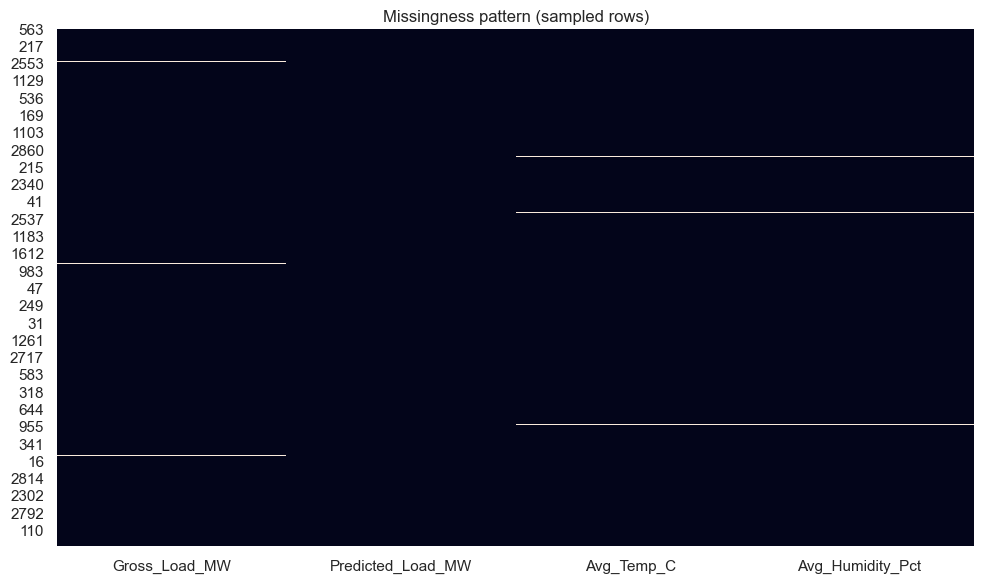

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subsample to avoid giant plot if df is huge
sample = df.sample(min(2000, len(df)), random_state=0)

plt.figure(figsize=(10, 6))
sns.heatmap(sample[["Gross_Load_MW", "Predicted_Load_MW", "Avg_Temp_C", "Avg_Humidity_Pct"]].isna(),
            cbar=False)
plt.title("Missingness pattern (sampled rows)")
plt.tight_layout()
plt.show()